In [7]:
#%pip install -r ../requirements.txt

In [8]:
# %pip install seaborn
# %pip install statsmodels
# %pip install pmdarima

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from pmdarima.arima import auto_arima
import pickle

# Step 2:

In [10]:
# Read data

df_raw_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-a.csv')
df_raw_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-train-b.csv')


test_a = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-a.csv')
test_b = pd.read_csv('https://raw.githubusercontent.com/oreilly-mlsec/book-resources/master/chapter3/datasets/cpu-utilization/cpu-test-b.csv')

In [11]:
# df_raw_a.to_csv('../data/raw/cpu-train-a.csv')
# df_raw_b.to_csv('../data/raw/cpu-train-b.csv')
# test_a .to_csv('../data/raw/cpu-test-a.csv')
# test_b .to_csv('../data/raw/cpu-test-b.csv')

In [12]:
df_raw_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  420 non-null    object 
 1   cpu       420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [13]:
df_raw_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  600 non-null    object 
 1   cpu       600 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [14]:
df_raw_a

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08
...,...,...
415,2017-01-28 01:37:00,2.41
416,2017-01-28 01:38:00,2.16
417,2017-01-28 01:39:00,1.93
418,2017-01-28 01:40:00,2.14


In [15]:
df_raw_b

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08
...,...,...
595,2017-01-28 04:37:00,1.45
596,2017-01-28 04:38:00,1.78
597,2017-01-28 04:39:00,1.77
598,2017-01-28 04:40:00,1.67


In [16]:
# Change variable type

df_interim_a = df_raw_a.copy()
df_interim_b = df_raw_b.copy()

df_interim_a['datetime'] = pd.to_datetime(df_interim_a['datetime'])
df_interim_b['datetime'] = pd.to_datetime(df_interim_b['datetime'])

In [17]:
# Set time as index because we are working with time series

df_interim_a = df_interim_a.set_index(df_interim_a['datetime'])
df_interim_b = df_interim_b.set_index(df_interim_b['datetime'])

In [18]:
df_interim_a

,datetime,cpu
datetime,,
2017-01-27 18:42:00,2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,2017-01-27 18:46:00,1.08
...,...,...
2017-01-28 01:37:00,2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,2017-01-28 01:39:00,1.93


In [19]:
# Drop variables

df_interim_a = df_interim_a.drop('datetime', axis=1)
df_interim_b = df_interim_b.drop('datetime', axis=1)

In [20]:
df_interim_a

,cpu
datetime,
2017-01-27 18:42:00,1.14
2017-01-27 18:43:00,1.10
2017-01-27 18:44:00,1.09
2017-01-27 18:45:00,1.08
2017-01-27 18:46:00,1.08
...,...
2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,1.93


In [21]:
df_a = df_interim_a.copy()
df_b = df_interim_b.copy()

In [22]:
df_a.describe()

,cpu
count,420.000000
mean,1.233262
std,0.505668
min,0.570000
25%,0.787500
50%,1.110000
75%,1.582500
max,2.550000


In [23]:
df_b.describe()

,cpu
count,600.000000
mean,1.282733
std,0.484951
min,0.570000
25%,0.840000
50%,1.240000
75%,1.610000
max,2.550000


# Step 3:

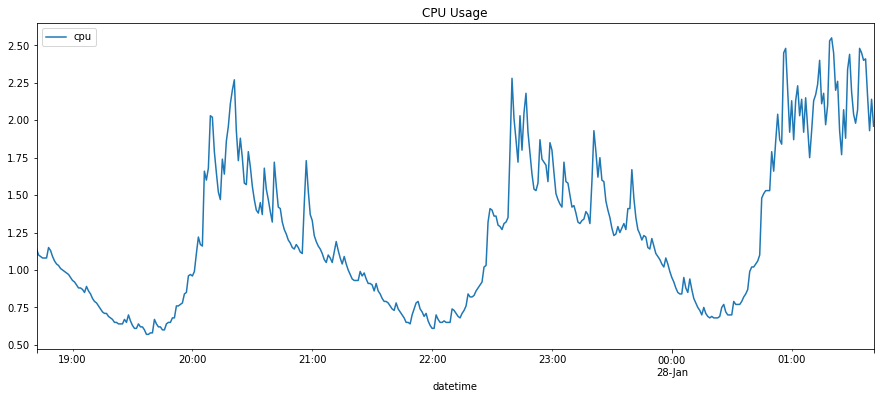

In [24]:
df_a.plot(title="CPU Usage", figsize=(15,6))
plt.show()

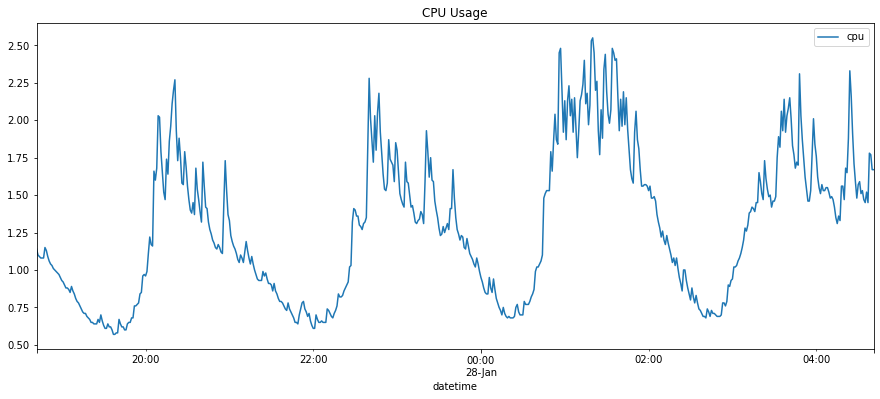

In [25]:
df_b.plot(title="CPU Usage", figsize=(15,6))
plt.show()

In [26]:
res = seasonal_decompose(df_a['cpu'].values, period=60) 

res_observed = res.observed
res_trend = res.trend
res_seasonal = res.seasonal
res_residual = res.resid

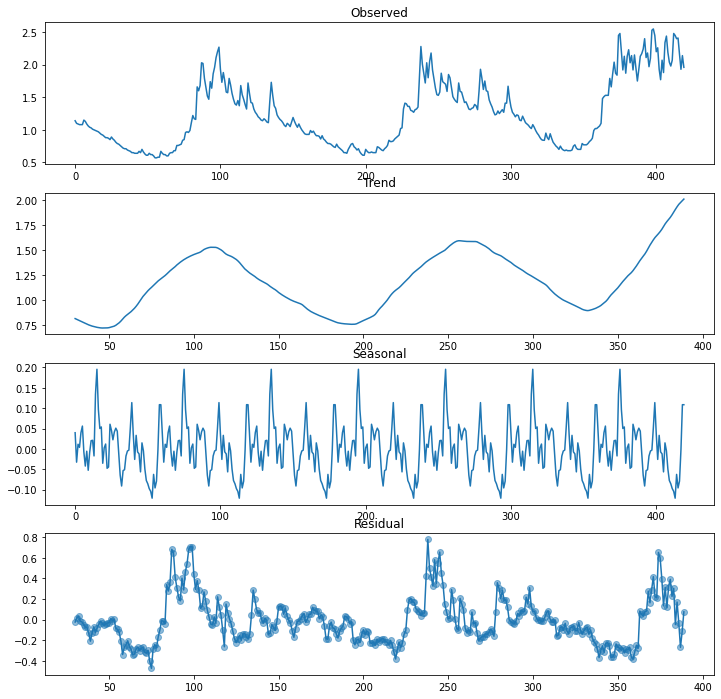

In [27]:
fig,ax = plt.subplots(4, figsize=(12,12))

ax[0].set_title('Observed')
ax[0].plot(res_observed)

ax[1].set_title('Trend')
ax[1].plot(res_trend)

ax[2].set_title('Seasonal')
ax[2].plot(res_seasonal)

ax[3].set_title('Residual')
ax[3].plot(res_residual)
ax[3].scatter(y=res_residual, x=range(len(res_residual)), alpha=0.5)

plt.show()

# Step 4:

In [28]:
stepwise_model = auto_arima(df_a, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-273.302, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-368.085, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-271.465, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-417.827, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-419.762, Time=0.68 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-369.850, Time=0.28 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-417.860, Time=0.64 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-421.259, Time=1.30 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-373.3

In [29]:
# Train the model

stepwise_model.fit(df_a)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

# Step 5:

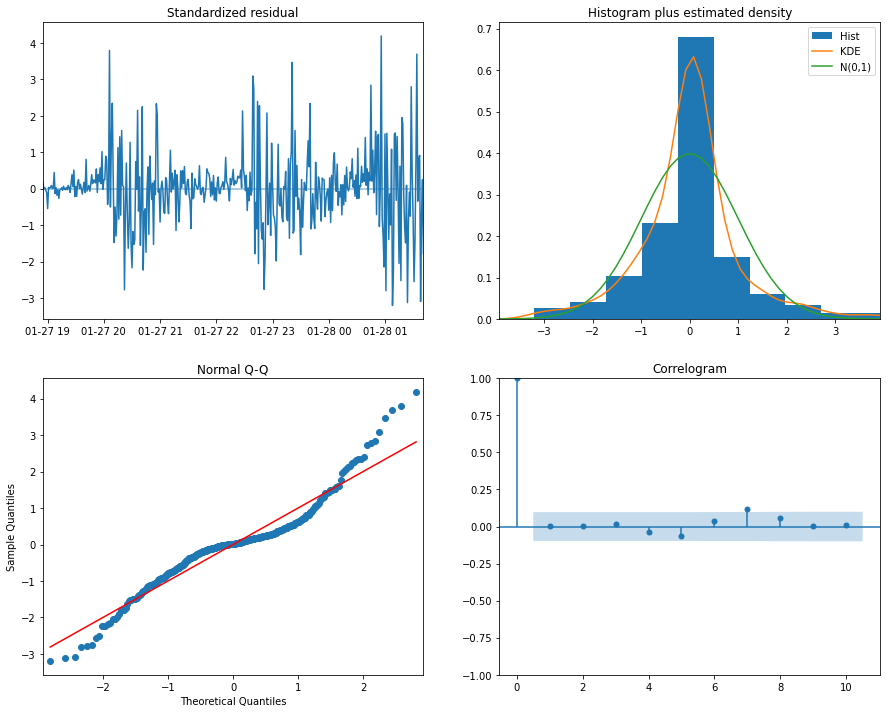

In [30]:
stepwise_model.fit(df_a).plot_diagnostics(figsize=(15, 12))
plt.show()

# Step 6:

In [31]:
test_a.shape

(60, 2)

In [32]:
test_a

,datetime,cpu
0,2017-01-28 01:42:00,2.19
1,2017-01-28 01:43:00,1.97
2,2017-01-28 01:44:00,2.15
3,2017-01-28 01:45:00,1.94
4,2017-01-28 01:46:00,1.81
5,2017-01-28 01:47:00,1.67
6,2017-01-28 01:48:00,1.61
7,2017-01-28 01:49:00,1.58
8,2017-01-28 01:50:00,1.92
9,2017-01-28 01:51:00,2.06


In [33]:
test_a['datetime'] = pd.to_datetime(test_a['datetime'])
test_a = test_a.set_index(test_a['datetime'])
test_a = test_a.drop('datetime', axis=1)

In [34]:
test_a

,cpu
datetime,
2017-01-28 01:42:00,2.19
2017-01-28 01:43:00,1.97
2017-01-28 01:44:00,2.15
2017-01-28 01:45:00,1.94
2017-01-28 01:46:00,1.81
2017-01-28 01:47:00,1.67
2017-01-28 01:48:00,1.61
2017-01-28 01:49:00,1.58
2017-01-28 01:50:00,1.92


In [35]:
df_pred_a=df_a.tail(100)
df_pred_a

,cpu
datetime,
2017-01-28 00:02:00,0.88
2017-01-28 00:03:00,0.85
2017-01-28 00:04:00,0.84
2017-01-28 00:05:00,0.84
2017-01-28 00:06:00,0.95
...,...
2017-01-28 01:37:00,2.41
2017-01-28 01:38:00,2.16
2017-01-28 01:39:00,1.93


In [36]:
test_a_final = pd.concat([df_pred_a, test_a])
test_a_final

,cpu
datetime,
2017-01-28 00:02:00,0.88
2017-01-28 00:03:00,0.85
2017-01-28 00:04:00,0.84
2017-01-28 00:05:00,0.84
2017-01-28 00:06:00,0.95
...,...
2017-01-28 02:37:00,0.73
2017-01-28 02:38:00,0.71
2017-01-28 02:39:00,0.69


In [37]:
test=test_a_final

In [38]:
future_forecast = stepwise_model.predict(n_periods=160)

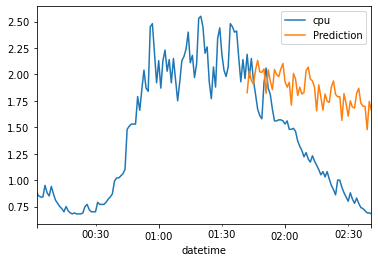

In [39]:
future_forecast = pd.DataFrame(future_forecast,index = test_a_final.index,columns=['Prediction'])
pd.concat([test_a_final,future_forecast],axis=1).plot()
plt.show()

In [49]:
#decido no gurdar los modelos pq son mas grandes que 100MB
#import pickle
# filename = '../models/model_a.pkl'
# pickle.dump(stepwise_model, open(filename,'wb'))

# Step 7:

In [41]:
stepwise_model_b = auto_arima(df_b, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_b.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-376.973, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-540.238, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-375.034, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-618.341, Time=1.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-619.706, Time=0.57 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-541.973, Time=0.31 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.69 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-618.493, Time=0.86 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-617.729, T

In [42]:
stepwise_model_b.fit(df_b)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

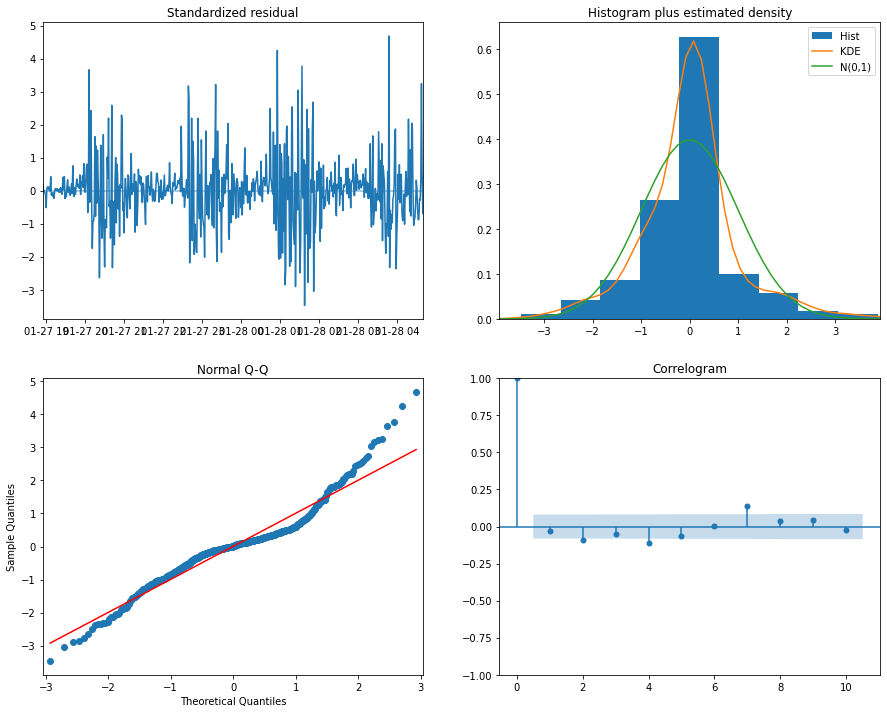

In [43]:
stepwise_model_b.fit(df_b).plot_diagnostics(figsize=(15, 12))
plt.show()

In [44]:
future_forecast_b = stepwise_model_b.predict(n_periods=160)

<AxesSubplot:xlabel='datetime'>

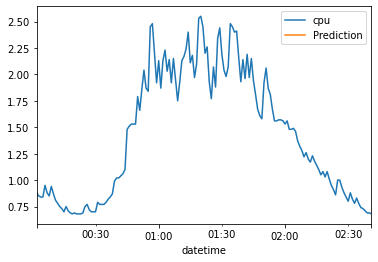

In [45]:
future_forecast_b = pd.DataFrame(future_forecast_b,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast_b],axis=1).plot()

In [51]:
# filename = '../models/model_b.pkl'
# pickle.dump(stepwise_model_b, open(filename,'wb'))

#Nota: se agrega la carpeta models a .gitignore porque son muy grandes